In [84]:
using Pkg

Pkg.add("PyPlot")
Pkg.add("NLsolve")

using PyPlot
using NLsolve
using LaTeXStrings
using LinearAlgebra


chi = 1.5                  # Scale parameter of labor
psi = 1.0                  # Elasticity of labor
rho = 1.01                 # Elasiticty of consumption
beta= 0.9

phi = range(0,             # Lagrange multiplier of the implementability constraint
            stop=1,
            length=100)     

G   = [0.1 0.2]'           # State-space of government expenditures

Pi  = [0.9 0.1;            # Markov transition matrix
       0.5 0.5];

 Resolving package versions...
  Updating `~/.julia/environments/v1.0/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.0/Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `~/.julia/environments/v1.0/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.0/Manifest.toml`
 [no changes]


## Part One
## Question A

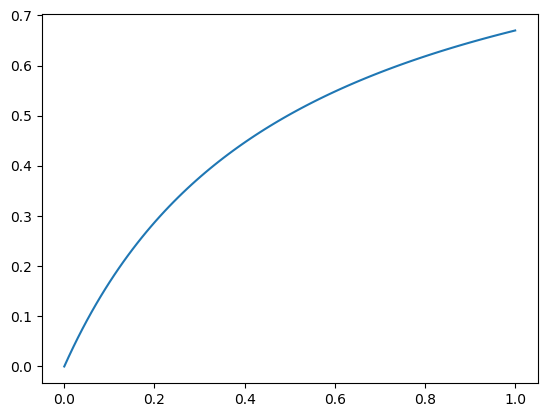

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x143589e48>

In [2]:
function tau(phi)
    1 .- (1 .+ phi .* (1 - rho)) ./ (1 .+ phi .* (1 + psi))
end

plot(phi, tau(phi))

## Question B

In [95]:
"""
Solves the time invariant allocation for a given government expenditure g and lagrange multiplier phi
"""
function timeInvariantAllocationSolver(g, phi)

    function f!(F, x)
        F[1] = x[1] - x[2] + g
        F[2] = x[1]^(- rho) * (1 + phi * (1 - rho)) - chi * x[2]^(psi) * (1 + phi * (1 + psi))
    end

    function j!(J, x)
        J[1, 1] = 1
        J[1, 2] = -1
        J[2, 1] = - rho * x[1]^(- rho - 1) * (1 + phi * (1 - rho))
        J[2, 2] = - chi * psi * x[2]^(psi - 1) * (1 + phi * (1 + psi))
    end

    nlsolve(f!, j!, [0.1; 0.1])
end

"""
Compute the time invariant allocation for a given set of governement expenditures and lagrange multiplier

Arguments:
    G: a vector of possible values for the government expenditures
    phi: a vector of possible values for phi

Return:
    (C, N): a tuple of matrices where X[i, j] is the time invariant allocation of X for g[i] and phi[j]
"""
function timeInvariantAllocation(G, phi)
    C = zeros(length(G), length(phi))
    N = zeros(length(G), length(phi))

    for (i, g) in enumerate(G)
        for (j, phi) in enumerate(phi)
            roots   = timeInvariantAllocationSolver(g, phi).zero
            C[i, j] = roots[1]
            N[i, j] = roots[2]
        end
    end

    return (C', N')
end

C, N = timeInvariantAllocation(G, phi)

([0.769097 0.723908; 0.760979 0.715835; … ; 0.425306 0.383372; 0.423706 0.381797], [0.869097 0.923908; 0.860979 0.915835; … ; 0.525306 0.583372; 0.523706 0.581797])

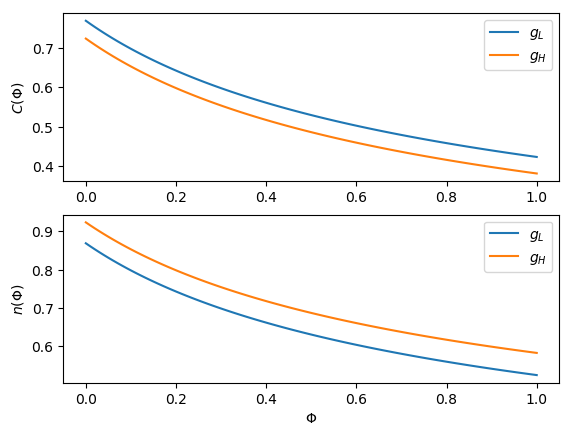

PyObject Text(0.5, 24.0, '$\\Phi$')

In [43]:
subplot(2,1,1)
plot(phi, C[:,:])
legend([L"$g_L$", L"$g_H$"])
ylabel(L"$C(\Phi)$")

subplot(2,1,2)
plot(phi, N[:,:])
legend([L"$g_L$", L"$g_H$"])
ylabel(L"$n(\Phi)$")
xlabel(L"$\Phi$")

## Question C

From the IC we have
$$
u_c(g)c(g) - u_x(g)(1-x(g)) + \beta \sum_{g'} \Pi(g'|g) u_c(g') b(g') - u_c(g)b(g) = 0
$$

In [120]:
"""
Compute a vector of marginal utilites for all states

Arguments:
    C  (ndArray): Matrix of consumption for each combination of g and phi
    N  (ndArray): Matrix of labor for each combination of g and phi

"""
function marginalUtilities(C, N)
    Uc = C.^(-rho)
    Un = -chi .* N .^ psi
    
    return (Uc, Un)
end

Uc, Un = marginalUtilities(C,N)

([1.30364 1.38586; 1.31769 1.40165; … ; 2.37143 2.63356; 2.38048 2.64453], [-1.30364 -1.38586; -1.29147 -1.37375; … ; -0.787959 -0.875057; -0.785559 -0.872696])

In [121]:
"""
Gives the debt policy of the government in function of the expenditures and the lagrange multiplier
"""
function bonds(Nstates, Nphi, C, N, Uc, Un, Pi, beta)
    b = zeros(Nstates, Nphi)
    Id = Matrix{Float64}(I, Nstates, Nstates)
    for i in 1:Nphi
        c = C[i,:]
        n = N[i,:]
        uc = Uc[i,:]
        un = Un[i,:]
        
        # The system writes:
        # b = Ab + E
        A  = beta .* (1 ./ uc) * uc' .* Pi
        E  = c .+ un./uc .* n
        
        b[:,i] = inv(Id - A) * E # We solve the system for a given phi
    end
    
    return b
end
                
B = bonds(length(G), length(phi), C, N, Uc, Un, Pi, beta)';

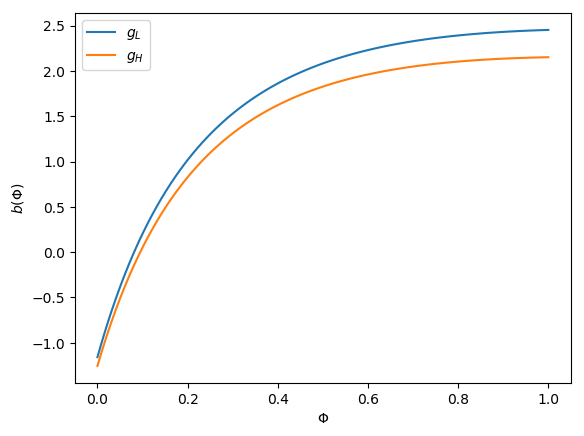

PyObject <matplotlib.legend.Legend object at 0x14e69bf28>

In [122]:
plot(phi, B[:,:])
xlabel(L"$\Phi$")
ylabel(L"$b(\Phi)$")
legend([L"$g_L$", L"$g_H$"])

# Part two

## Question 1


In [245]:
"""
Solves the time invariant allocation for a given government expenditure g and lagrange multiplier phi
"""
function timeZeroAllocationSolver(g, phi, b0)

    function f!(F, x)
        F[1] = x[1] - x[2] + g
        F[2] = (1 + phi) * (x[1]^(- rho) - chi * x[2]^psi) -
                phi * (rho * x[1]^(x[1] - b0) + chi * psi * x[2]^(psi - 1)) 
    end

    nlsolve(f!, [0.5; 0.5])
end

function timeZeroAllocation(g, phi, b0)
    C0 = Matrix(undef, length(phi), length(b0))
    N0 = Matrix(undef, length(phi), length(b0))
    
    for (i, phi) in enumerate(phi)
        for (j, b0) in enumerate(b0)
            roots   = timeZeroAllocationSolver(g, phi, b0).zero
            C0[i, j] = roots[1]
            N0[i, j] = roots[2]
        end
    end
    
    return (C0, N0)
end

timeZeroAllocation (generic function with 1 method)

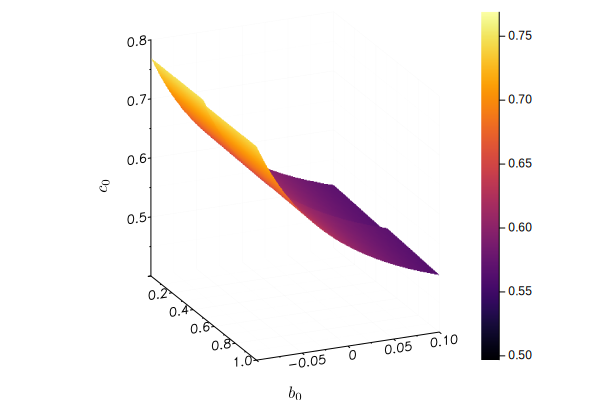

In [321]:
b0 = range(-0.1, stop=0.1, length=50)

C0, N0 = timeZeroAllocation(G[1], phi, b0)

surface(phi, b0, C0, camera = (60, 40), xlabel=L"$b_0$", ylabel=L"$c_0$")